<a href="https://colab.research.google.com/github/klouderm/DS6290_RMS/blob/main/Assignment_1/assign_1_kylieLoudermilk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## License 

Copyright 2021-2023 Patrick Hall (jphall@gwu.edu)

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

*DISCLAIMER*: This notebook is not legal or compliance advice.

# Assignment 1 Template

In [ ]:
!pip install interpret
!pip install h2o

#### Imports and inits

In [ ]:
import datetime                                               # for timestamp 
import h2o                                                    # base h2o package for python
from h2o.estimators.glm import H2OGeneralizedLinearEstimator  # h2o elastic net models class
from h2o.grid.grid_search import H2OGridSearch                # grid search class and syntax for h2o models
from interpret import show                                    # basic visualizations from interpret package
from interpret.glassbox import ExplainableBoostingClassifier  # interpret ebm class
from interpret.perf import ROC                                # ROC measure for ebm
import itertools                                              # for cartesian product of parameters
import matplotlib.pyplot as plt                               # basic plotting
import numpy as np                                            # for basic array manipulation                            
import pandas as pd                                           # for dataframe manipulation
import seaborn as sns                                         # slightly better plotting  
import time                                                   # for timers
import xgboost as xgb                                         # base xgboost package for python

# set numpy random seed for better reproducibility
SEED = 12345 

# set number of threads
NTHREAD = 4

h2o.init(max_mem_size='6G', nthreads=NTHREAD) # start h2o with plenty of memory and threads
h2o.remove_all()                              # clears h2o memory
h2o.no_progress()                             # turn off h2o progress indicators    

#### Start global timer

In [3]:
tic = time.time()

In [ ]:
import io
from google.colab import files
from google.colab import drive
uploaded = files.upload() # upload training and test data
import pandas as pd
train = pd.read_csv(io.StringIO(uploaded['hmda_train_preprocessed.csv'].decode('utf-8')))
test = pd.read_csv(io.StringIO(uploaded['hmda_test_preprocessed.csv'].decode('utf-8')))
!pip install piml
from piml import Experiment
exp = Experiment()
#exp.data_loader(data=train)

In [54]:
drive.mount('/drive', force_remount=True)

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

Mounted at /drive


#### Import data

In [6]:
#data = pd.read_csv('../data/hmda_train_preprocessed.csv')
#test = pd.read_csv('../data/hmda_test_preprocessed.csv')
data=train

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

#### Assign basic modeling roles

In [7]:
y_name = 'high_priced'
x_names = ['term_360', 'conforming', 'debt_to_income_ratio_missing', 'loan_amount_std', 'loan_to_value_ratio_std', 'no_intro_rate_period_std',
           'intro_rate_period_std', 'property_value_std', 'income_std', 'debt_to_income_ratio_std']

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

## Basic data exploration

#### Histograms

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

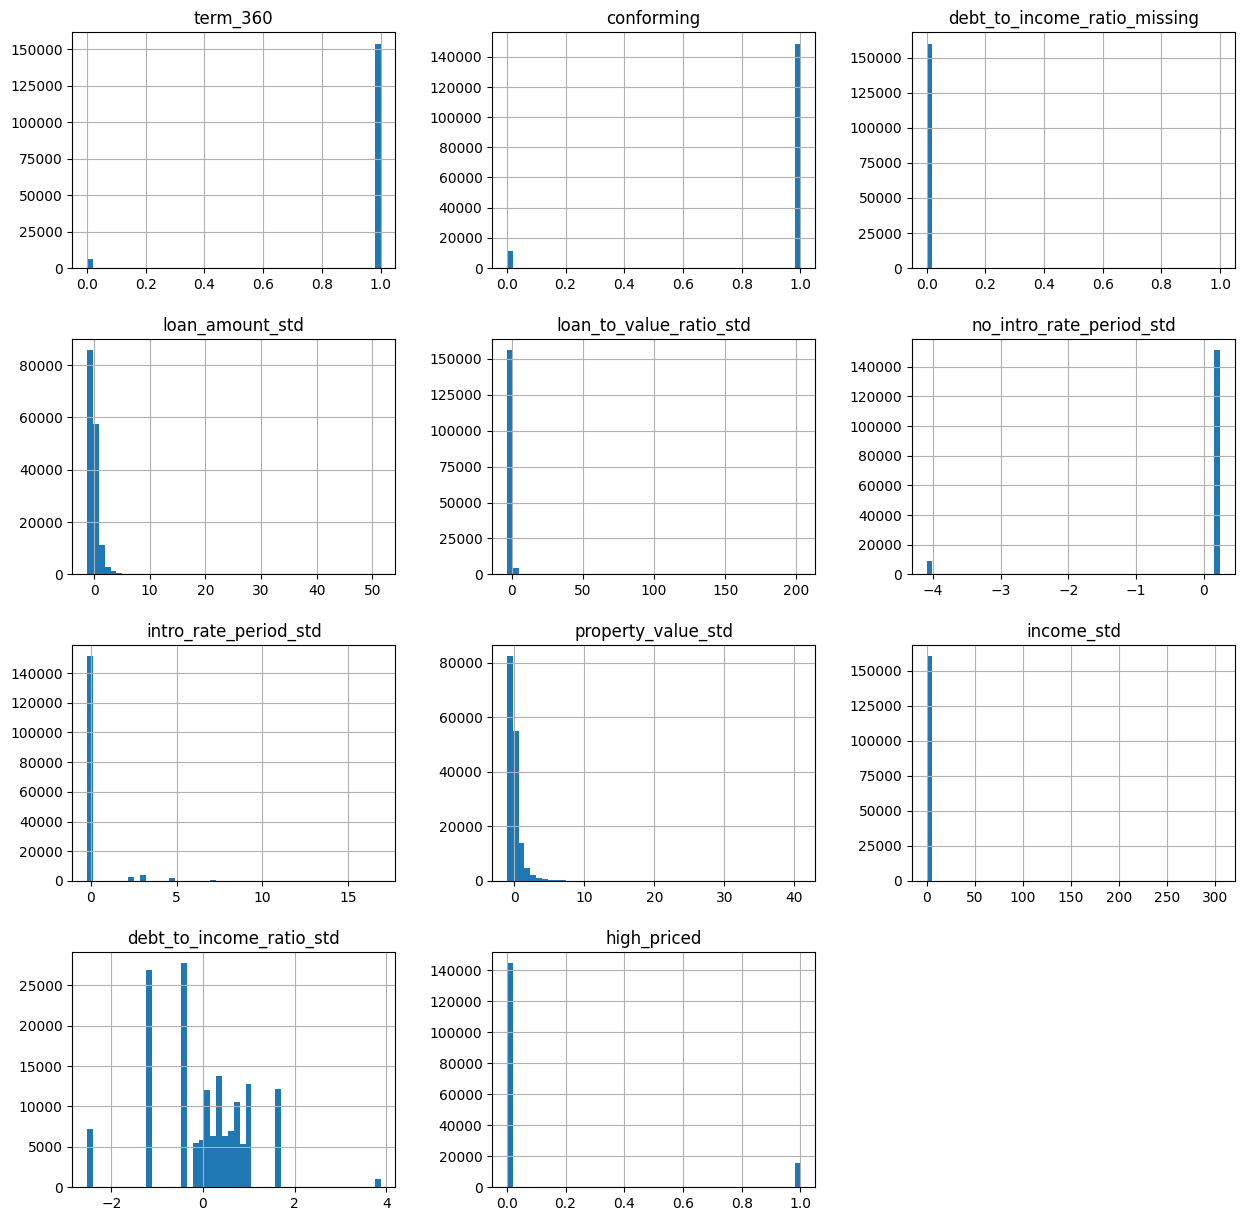

In [64]:
_ = data[x_names + [y_name]].hist(bins=50, figsize=(15, 15))

#### Correlations

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

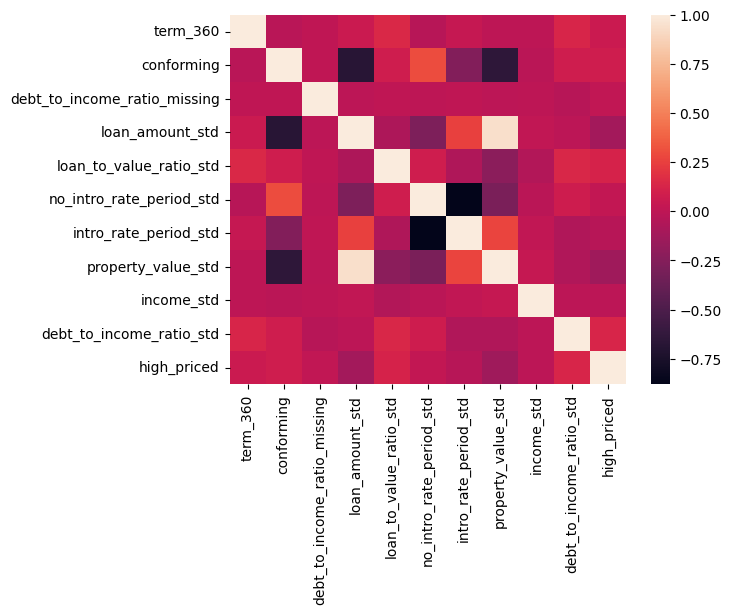

In [65]:
corr = data[x_names + [y_name]].corr()
_ = sns.heatmap(corr, 
                xticklabels=corr.columns.values,
                yticklabels=corr.columns.values)

## Fit interpretable models

#### Split data into train and validation partitions 

In [8]:
np.random.seed(SEED) # preserve exact reproducibility for this cell

split_ratio = 0.7 # 70%/30% train/test split

# execute split
split = np.random.rand(len(data)) < split_ratio
train = data[split]
valid = data[~split]

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Validation data rows = %d, columns = %d' % (valid.shape[0], valid.shape[1]))

exp.data_loader(data=train[x_names+[y_name]])
exp.data_prepare()

# benchmark - Train data rows = 112253, columns = 23
# benchmark - Validation data rows = 48085, columns = 23

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

Train data rows = 112253, columns = 23
Validation data rows = 48085, columns = 23


,term_360,conforming,debt_to_income_ratio_missing,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,high_priced
0,1.0,1.0,0.0,-0.118642,0.268727,0.244394,-0.215304,-0.227585,-0.018133,-0.425131,0.0
1,1.0,1.0,0.0,-0.778227,0.228996,-4.091747,4.610857,-0.720941,-0.032338,0.123326,0.0
2,1.0,1.0,0.0,-0.074670,-1.150240,0.244394,-0.215304,0.358276,-0.018133,-0.425131,0.0
3,1.0,1.0,0.0,-0.602338,0.552520,0.244394,-0.215304,-0.628437,-0.038228,0.763191,0.0
4,1.0,1.0,0.0,-0.338504,0.372784,0.244394,-0.215304,-0.412593,-0.024716,0.397554,0.0
...,...,...,...,...,...,...,...,...,...,...,...
112248,1.0,1.0,0.0,0.189165,-0.227057,0.244394,-0.215304,0.173267,-0.013628,-0.425131,0.0
112249,1.0,1.0,0.0,0.365054,0.663316,0.244394,-0.215304,0.019094,-0.015361,1.585876,0.0
112250,1.0,0.0,0.0,9.599253,-0.463082,-4.091747,2.197776,9.084518,0.270486,0.397554,0.0
112251,1.0,1.0,0.0,-0.998089,0.552520,0.244394,-0.215304,-0.905950,-0.039614,-0.425131,0.0


Training a few models at the same time to compare the output

In [9]:
exp.model_train()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

In [10]:
exp.model_diagnose()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

In [11]:
exp.model_compare()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

### GAMI-NET

Training GAMI-NET model

In [56]:
from piml.models import GAMINetClassifier
exp.model_train(model=GAMINetClassifier(), name='GAMI-NET')

exp.model_diagnose(model='GAMI-NET', show='accuracy_table')

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

,ACC,AUC,Recall,Precision,F1
,,,,,
Train,0.9021,0.8033,0.0191,0.3327,0.0362
Test,0.8952,0.8022,0.0143,0.2797,0.0273
Gap,-0.0068,-0.0012,-0.0048,-0.0530,-0.0089


Generating predictions based on test data with GAMI-NET model

In [57]:
GNpreds = exp.experiment.registered_pipeline['GAMI-NET'].predict_proba(test[x_names].values)[:, 1]

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

Exporting predictions as csv

In [58]:
best_gn_submit = pd.DataFrame(GNpreds, columns=['phat'])
filename = '/drive/My Drive/Assignment1/kylieLoudermilk_best_gaminet_' + str(datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S") + '.csv')
best_gn_submit.to_csv(filename,
                        index=False)

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

### XGBoost Depth 2

Training XGBoost Depth 2 Model

In [14]:
from piml.models import XGB2Classifier
exp.model_train(model=XGB2Classifier(), name='XGB_2')


# start local timer
mxgb2_tic = time.time()


HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

In [15]:
exp.model_diagnose(model='XGB_2', show='accuracy_table')

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

,ACC,AUC,Recall,Precision,F1
,,,,,
Train,0.9041,0.8262,0.0056,0.5926,0.0110
Test,0.8975,0.8212,0.0043,0.4545,0.0086
Gap,-0.0066,-0.0050,-0.0012,-0.1380,-0.0024


Generating predictions based on test data with XGBoost Depth 2 model

In [22]:
XGB2preds = exp.experiment.registered_pipeline['XGB_2'].predict_proba(test[x_names].values)[:, 1]

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

Exporting predictions as csv

In [ ]:
best_xgb2_submit = pd.DataFrame(XGB2preds, columns=['phat'])
filename = '/drive/My Drive/Assignment1/kylieLoudermilk_best_xgb2_' + str(datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S") + '.csv')
best_xgb2_submit.to_csv(filename,
                        index=False)

### ReluDNN

Training ReluDNN Model

In [59]:
from piml.models import ReluDNNClassifier
exp.model_train(model=ReluDNNClassifier(), name='ReluDNN')


# start local timer
_tic = time.time()


HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

In [61]:
exp.model_diagnose(model='ReluDNN', show='accuracy_table')

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

,ACC,AUC,Recall,Precision,F1
,,,,,
Train,0.9039,0.8066,0.0021,0.5143,0.0042
Test,0.8971,0.8076,0.0004,0.0833,0.0009
Gap,-0.0068,0.0010,-0.0017,-0.4310,-0.0033


Generating predictions based on test data with ReluDNN model

In [62]:
ReluDNNpreds = exp.experiment.registered_pipeline['ReluDNN'].predict_proba(test[x_names].values)[:, 1]

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

Exporting predictions as csv

In [63]:
best_reludnn_submit = pd.DataFrame(ReluDNNpreds, columns=['phat'])
filename = '/drive/My Drive/Assignment1/kylieLoudermilk_best_reludnn_' + str(datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S") + '.csv')
best_reludnn_submit.to_csv(filename,
                        index=False)

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…